In [71]:
#pip install torch-geometric
#pip install torch
#pip install numpy --upgrade

In [72]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import torch_geometric.utils as utils
import torch
import torch.nn.functional as F
from torch_geometric.utils import subgraph
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GATConv

In [73]:
df1 = pd.read_excel("radicalism/PIRUS_V4.xlsx")
df2 = pd.read_excel("radicalism/SoNAR_Edges.xlsx")
df3 = pd.read_excel("radicalism/SoNAR_Nodes.xlsx")

In [74]:
df1

,Subject_ID,Loc_Plot_State1,Loc_Plot_City1,Loc_Plot_State2,Loc_Plot_City2,Year_Exposure,Plot_Target1,Plot_Target2,Plot_Target3,Attack_Preparation,...,Trauma,Other_Ideologies,Angry_US,Group_Grievance,Component_ID,Component_Density,Lone_Offender,Degree_Centrality,Betweenness_Centrality,Closeness_Centrality
0,1000,Illinois,Chicago,Florida,Broward County,2002,14,NaN,NaN,1,...,0,0,0,0,6,0.190000,0,5,0.112319,0.444444
1,1001,California,San Francisco,NaN,NaN,2001,-88,NaN,NaN,-88,...,-99,0,1,-99,1525,-88.000000,1,0,0.000000,0.000000
2,1002,California,Santa Ana,NaN,NaN,1997,-99,NaN,NaN,-99,...,-99,0,1,1,471,1.000000,0,1,0.000000,1.000000
3,1005,New York,New York,NaN,NaN,1993,1,NaN,NaN,2,...,0,0,1,2,9,0.573099,0,9,0.179739,0.666667
4,1006,New York,New York,NaN,NaN,1993,1,NaN,NaN,2,...,-99,0,1,-99,9,0.573099,0,9,0.179739,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198,12147,District of Columbia,Washington,NaN,NaN,2021,2,3.0,NaN,1,...,0,0,1,0,1535,-88.000000,1,0,0.000000,0.000000
3199,12148,District of Columbia,Washington,NaN,NaN,2021,2,3.0,NaN,1,...,0,0,1,0,38,0.527778,0,3,0.428571,0.615385
3200,12149,Oregon,Salem,NaN,NaN,2021,14,NaN,NaN,-99,...,0,0,0,0,1,0.005436,0,4,0.000000,0.098882
3201,12151,Oregon,Salem,NaN,NaN,2021,14,NaN,NaN,-99,...,0,0,0,0,1,0.005436,0,4,0.000000,0.098882


In [75]:
df1.isnull().sum()

Subject_ID                   0
Loc_Plot_State1              0
Loc_Plot_City1               0
Loc_Plot_State2           2939
Loc_Plot_City2            2965
                          ... 
Component_Density            0
Lone_Offender                0
Degree_Centrality            0
Betweenness_Centrality       0
Closeness_Centrality         0
Length: 130, dtype: int64

In [76]:
df1.dropna(axis=1, how='any', inplace=True)

In [77]:
# Make sure that we have no duplicate nodes
max(df1["Subject_ID"].value_counts())

1

In [78]:
state_dict = {state: i for i, state in enumerate(df1['Loc_Plot_State1'].unique())}
df1['Loc_Plot_State1'] = df1['Loc_Plot_State1'].map(state_dict)

In [79]:
city_dict = {}
for state in df1['Loc_Plot_State1'].unique():
    cities = df1[df1['Loc_Plot_State1'] == state]['Loc_Plot_City1'].unique()
    city_dict[state] = {city: i for i, city in enumerate(cities)}
df1['Loc_Plot_City1'] = df1.apply(lambda x: city_dict[x['Loc_Plot_State1']][x['Loc_Plot_City1']], axis=1)


In [80]:
df1['Loc_Plot_State1'] = df1['Loc_Plot_State1'].astype(int)
df1['Loc_Plot_City1'] = df1['Loc_Plot_City1'].astype(int)

In [81]:
df1 = df1.merge(df3, on='Subject_ID')

In [82]:
labels = df1[["Ideology"]]

In [83]:
print(labels.Ideology.unique())

['Islamist' 'White Supremacist/Nativist'
 'Anti-Government/Sovereign Citizen' 'Environmental/Animal Rights' 'Other'
 'Conspiracy Theory' 'Anarchist/Anti-Capitalist' 'Anti-Abortion'
 'Black Nationalist/Separatist']


In [84]:
label_dict = {state: i for i, state in enumerate(labels['Ideology'].unique())}
labels['Ideology'] = labels['Ideology'].map(label_dict)
labels['Ideology'] = labels['Ideology'].astype(int)

C:\Users\Razaq\AppData\Local\Temp\ipykernel_9952\58358649.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['Ideology'] = labels['Ideology'].map(label_dict)
C:\Users\Razaq\AppData\Local\Temp\ipykernel_9952\58358649.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['Ideology'] = labels['Ideology'].astype(int)


In [85]:
print(labels)
print(labels.Ideology.unique())

      Ideology
0            0
1            0
2            0
3            0
4            0
...        ...
3198         1
3199         1
3200         1
3201         1
3202         1

[3203 rows x 1 columns]
[0 1 2 3 4 5 6 7 8]


In [86]:
df1 = df1.drop(['Ideology', 'Decade',	'In_PIRUS'], axis=1)

In [87]:
string_columns = df1.select_dtypes(include=['object']).columns

# convert string columns to numeric encoding
for col in string_columns:
    df1[col] = pd.Categorical(df1[col]).codes

C:\Users\Razaq\AppData\Roaming\Python\Python310\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [88]:
df2 = df2.dropna()

In [89]:
scaler = StandardScaler()
x = scaler.fit_transform(df1.iloc[:, 2:].values)

x = torch.from_numpy(x).float()
y = torch.from_numpy(labels['Ideology'].values).float()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

df2['Subject_A'] = pd.factorize(df2['Subject_A'])[0]
df2['Subject_B'] = pd.factorize(df2['Subject_B'])[0]

edges = np.array(df2[['Subject_A', 'Subject_B']])

num_nodes = len(np.unique(edges))
edge_index = torch.from_numpy(edges.T).long()
edge_index -= edge_index.min()  # Shift indices to start from zero

# Normalize edge_index
edge_index = edge_index / num_nodes

edge_index_train, edge_index_test = train_test_split(edge_index.t(), test_size=0.2, random_state=42)


edge_index_train = edge_index_train.t()
edge_index_test = edge_index_test.t()

# Ensure that the indices are within the valid range
num_nodes_train = x_train.size(0)
num_edges_train = edge_index_train.size(1)
edge_index_train = torch.tensor(edge_index_train, dtype=torch.long)

# Ensure that the indices are within the valid range
edge_index_train = edge_index_train.remainder(num_nodes_train)

# Create edge_index_test
num_nodes_test = x_test.size(0)
num_edges_test = edge_index_test.size(1)
edge_index_test = torch.tensor(edge_index_test, dtype=torch.long)

# Ensure that the indices are within the valid range
edge_index_test = edge_index_test.remainder(num_nodes_test)

C:\Users\Razaq\AppData\Local\Temp\ipykernel_9952\4233337203.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_train = torch.tensor(edge_index_train, dtype=torch.long)
C:\Users\Razaq\AppData\Local\Temp\ipykernel_9952\4233337203.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_test = torch.tensor(edge_index_test, dtype=torch.long)


In [90]:
import torch

unique_labels, label_counts = torch.unique(y_train, return_counts=True)
print(unique_labels)
print(label_counts)

print('x_train: ', x_train.shape)
print('x_test: ', x_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)
print('edge_index_train: ', edge_index_train.shape)
print('edge_index_test: ', edge_index_test.shape)

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.])
tensor([476, 778, 448, 143, 213,  99, 201, 112,  92])
x_train:  torch.Size([2562, 90])
x_test:  torch.Size([641, 90])
y_train:  torch.Size([2562])
y_test:  torch.Size([641])
edge_index_train:  torch.Size([2, 11065])
edge_index_test:  torch.Size([2, 2767])


In [91]:
num_features = x_train.size(1) 
hidden_dim = 320
num_classes = 9
num_layers = 5
dropout_rate = 0.5

In [92]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()

        self.conv1 = GraphConv(num_features, hidden_dim)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GraphConv(hidden_dim, hidden_dim))
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x, edge_index):
       
        x = F.relu(self.conv1(x, edge_index))

        for conv in self.convs:       
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

model = GCN()
print(model)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
test_losses = []
test_accs = []
# Train the model for a certain number of epochs
for epoch in range(1000):
    # Train step
    model.train()
    optimizer.zero_grad()

    output = model(x_train, edge_index_train)
    
    train_loss = criterion(output, y_train.long())
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    # Test step
    model.eval()
    with torch.no_grad():
        output = model(x_test, edge_index_test)
        test_loss = criterion(output, y_test.long())
        test_losses.append(test_loss.item())
        predictions = output.argmax(dim=1)
        test_acc = (predictions == y_test.long()).sum().item() / len(y_test)
        test_accs.append(test_acc)

    # Print progress every 50 epochs
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_acc:.4f}")


GCN(
  (conv1): GraphConv(90, 320)
  (convs): ModuleList(
    (0-3): 4 x GraphConv(320, 320)
  )
  (fc): Linear(in_features=320, out_features=9, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch 0: Train Loss: 2.2080, Test Loss: 10516706623488.0000, Test Accuracy: 0.3058
Epoch 50: Train Loss: 0.7527, Test Loss: 20455544103895040.0000, Test Accuracy: 0.6131
Epoch 100: Train Loss: 0.4219, Test Loss: 25781032967995392.0000, Test Accuracy: 0.7083
Epoch 150: Train Loss: 0.2821, Test Loss: 27427261720297472.0000, Test Accuracy: 0.7566
Epoch 200: Train Loss: 0.2175, Test Loss: 29641347426156544.0000, Test Accuracy: 0.7754
Epoch 250: Train Loss: 0.1829, Test Loss: 30763182146453504.0000, Test Accuracy: 0.7707
Epoch 300: Train Loss: 0.1786, Test Loss: 28824768916488192.0000, Test Accuracy: 0.7426
Epoch 350: Train Loss: 0.1698, Test Loss: 28603182963752960.0000, Test Accuracy: 0.7676
Epoch 400: Train Loss: 0.1800, Test Loss: 28710063224913920.0000, Test Accuracy: 0.7598
Epoch 450: Tr

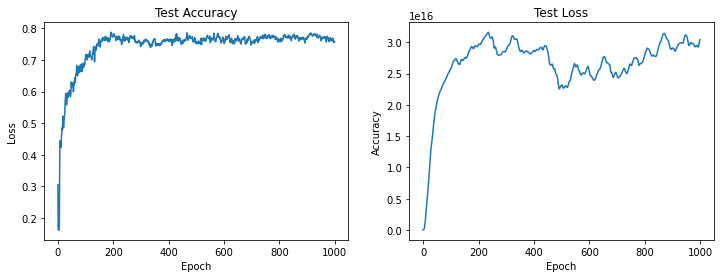

In [93]:
    # Plot the loss and accuracy graphs
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(test_accs)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Test Accuracy")
ax[1].plot(test_losses)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Test Loss")
plt.show()

In [94]:
my_list = list(label_dict.keys())
print(my_list)

['Islamist', 'White Supremacist/Nativist', 'Anti-Government/Sovereign Citizen', 'Environmental/Animal Rights', 'Other', 'Conspiracy Theory', 'Anarchist/Anti-Capitalist', 'Anti-Abortion', 'Black Nationalist/Separatist']


In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualize(h, color, labels):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2", label=labels)
    plt.legend(handles=scatter.legend_elements()[0], labels=labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

Accuracy: 0.7582
Confusion Matrix:
[[103   0   0   0   1   0   0   0   0]
 [  0 165  27   1   0   3   0   0   0]
 [  0  36  58   0   0  13   1   2   0]
 [  0   0   0  37   0   0   1   0   4]
 [  0   3   1   1  29   0   0  14   1]
 [  0   4   3   0   1  15   0   3   1]
 [  0   0   1   2   1   0  37   1  10]
 [  0   1   0   0   8   0   0  23   0]
 [  0   1   0   2   0   3   2   2  19]]
Classification Report:
                                   precision    recall  f1-score   support

                         Islamist       1.00      0.99      1.00       104
       White Supremacist/Nativist       0.79      0.84      0.81       196
Anti-Government/Sovereign Citizen       0.64      0.53      0.58       110
      Environmental/Animal Rights       0.86      0.88      0.87        42
                            Other       0.72      0.59      0.65        49
                Conspiracy Theory       0.44      0.56      0.49        27
        Anarchist/Anti-Capitalist       0.90      0.71      0.80

C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:102: RuntimeWarning: overflow encountered in cast
  distances_data = distances_data.astype(np.float32, copy=False)


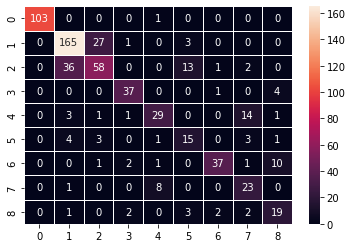

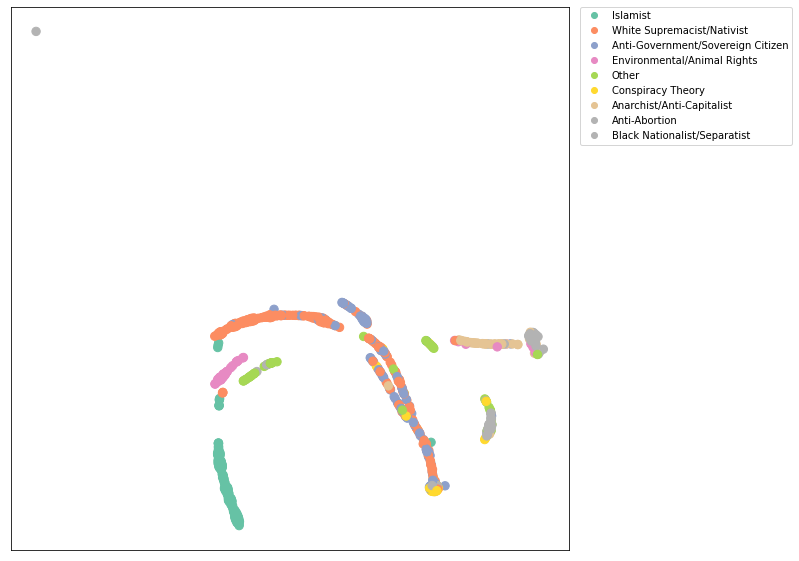

In [96]:
model.eval()
with torch.no_grad():
    output = model(x_test, edge_index_test)
    predictions = output.argmax(dim=1)
    accuracy = (predictions == y_test.long()).sum().item() / len(y_test)
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, predictions)
    print(cm)
    sns.heatmap(cm, linewidths=1, annot=True, fmt='g')
    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=my_list))
    visualize(output, y_test, my_list)

In [97]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()

        self.conv1 = SAGEConv(num_features, hidden_dim)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
        self.fc = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.dropout(x, p=dropout_rate, training=self.training)
            x = F.relu(conv(x, edge_index))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

model = GraphSAGE()
print(model)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
test_losses = []
test_accs = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    output = model(x_train, edge_index_train)  
    train_loss = criterion(output, y_train.long())
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

  
    model.eval()
    with torch.no_grad():
        output = model(x_test, edge_index_test)
        test_loss = criterion(output, y_test.long())
        test_losses.append(test_loss.item())
        predictions = output.argmax(dim=1)
        test_acc = (predictions == y_test.long()).sum().item() / len(y_test)
        test_accs.append(test_acc)


    # Print progress every 50 epochs
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_acc:.4f}")

GraphSAGE(
  (conv1): SAGEConv(90, 320, aggr=mean)
  (convs): ModuleList(
    (0-3): 4 x SAGEConv(320, 320, aggr=mean)
  )
  (fc): Linear(in_features=320, out_features=9, bias=True)
)
Epoch 0: Train Loss: 2.1987, Test Loss: 3.9331, Test Accuracy: 0.3058
Epoch 50: Train Loss: 1.5126, Test Loss: 1.4291, Test Accuracy: 0.4852
Epoch 100: Train Loss: 1.3327, Test Loss: 1.2942, Test Accuracy: 0.5195
Epoch 150: Train Loss: 1.3100, Test Loss: 1.3120, Test Accuracy: 0.4867
Epoch 200: Train Loss: 1.2969, Test Loss: 1.4246, Test Accuracy: 0.4353
Epoch 250: Train Loss: 1.2750, Test Loss: 1.4303, Test Accuracy: 0.4165
Epoch 300: Train Loss: 1.2778, Test Loss: 1.4550, Test Accuracy: 0.4384
Epoch 350: Train Loss: 1.3302, Test Loss: 1.4549, Test Accuracy: 0.4197
Epoch 400: Train Loss: 1.2851, Test Loss: 1.2654, Test Accuracy: 0.5523
Epoch 450: Train Loss: 1.2801, Test Loss: 1.3441, Test Accuracy: 0.4961
Epoch 500: Train Loss: 1.3087, Test Loss: 1.2769, Test Accuracy: 0.5008
Epoch 550: Train Loss: 1.28

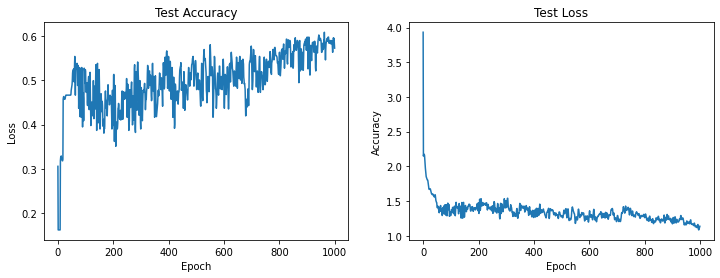

In [98]:
    # Plot the loss and accuracy graphs
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(test_accs)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Test Accuracy")
ax[1].plot(test_losses)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Test Loss")
plt.show()

Accuracy: 0.5725
Confusion Matrix:
[[ 89   0   0   0  14   0   1   0   0]
 [  0 196   0   0   0   0   0   0   0]
 [  0 108   0   0   0   0   2   0   0]
 [  0   1   0   0   0   0  41   0   0]
 [  0   5   0   0  31   0  13   0   0]
 [  0  25   0   0   0   0   2   0   0]
 [  0   1   0   0   0   0  51   0   0]
 [  0   1   0   0  18   0  13   0   0]
 [  0   1   0   0   1   0  27   0   0]]
Classification Report:
                                   precision    recall  f1-score   support

                         Islamist       1.00      0.86      0.92       104
       White Supremacist/Nativist       0.58      1.00      0.73       196
Anti-Government/Sovereign Citizen       0.00      0.00      0.00       110
      Environmental/Animal Rights       0.00      0.00      0.00        42
                            Other       0.48      0.63      0.55        49
                Conspiracy Theory       0.00      0.00      0.00        27
        Anarchist/Anti-Capitalist       0.34      0.98      0.50

C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

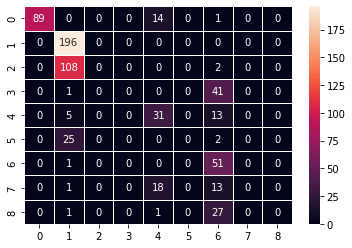

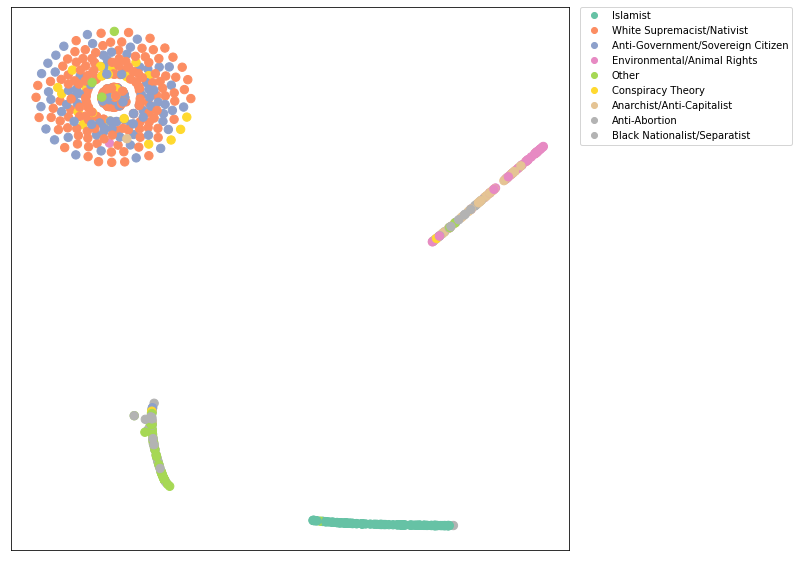

In [99]:
model.eval()
with torch.no_grad():
    output = model(x_test, edge_index_test)
    predictions = output.argmax(dim=1)
    accuracy = (predictions == y_test.long()).sum().item() / len(y_test)
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, predictions)
    print(cm)
    sns.heatmap(cm, linewidths=1, annot=True, fmt='g')
    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=my_list))
    visualize(output, y_test, my_list)

In [100]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()

        self.conv1 = GATConv(num_features, hidden_dim, heads=8, dropout=dropout_rate)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GATConv(hidden_dim * 8, hidden_dim, heads=8, dropout=dropout_rate))
        self.fc = torch.nn.Linear(hidden_dim * 8, num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.dropout(x, p=dropout_rate, training=self.training)
            x = F.elu(conv(x, edge_index))
        x = torch.cat([x[:, i::8 * hidden_dim] for i in range(8 * hidden_dim)], dim=1)  # Concatenate attention heads
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


model = GAT()
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
test_losses = []
test_accs = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    output = model(x_train, edge_index_train)  
    train_loss = criterion(output, y_train.long())
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

  
    model.eval()
    with torch.no_grad():
        output = model(x_test, edge_index_test)
        test_loss = criterion(output, y_test.long())
        test_losses.append(test_loss.item())
        predictions = output.argmax(dim=1)
        test_acc = (predictions == y_test.long()).sum().item() / len(y_test)
        test_accs.append(test_acc)


    # Print progress every 50 epochs
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_acc:.4f}")

GAT(
  (conv1): GATConv(90, 320, heads=8)
  (convs): ModuleList(
    (0-3): 4 x GATConv(2560, 320, heads=8)
  )
  (fc): Linear(in_features=2560, out_features=9, bias=True)
)
Epoch 0: Train Loss: 2.8766, Test Loss: 2.1377, Test Accuracy: 0.2855
Epoch 50: Train Loss: 1.7615, Test Loss: 0.9619, Test Accuracy: 0.5928
Epoch 100: Train Loss: 1.4495, Test Loss: 0.9043, Test Accuracy: 0.6537
Epoch 150: Train Loss: 1.3024, Test Loss: 0.9746, Test Accuracy: 0.6661
Epoch 200: Train Loss: 1.1842, Test Loss: 0.9929, Test Accuracy: 0.6677
Epoch 250: Train Loss: 1.2154, Test Loss: 1.0379, Test Accuracy: 0.6661
Epoch 300: Train Loss: 1.1826, Test Loss: 1.0157, Test Accuracy: 0.6817
Epoch 350: Train Loss: 1.1416, Test Loss: 1.0515, Test Accuracy: 0.6693
Epoch 400: Train Loss: 1.1075, Test Loss: 1.0469, Test Accuracy: 0.6724
Epoch 450: Train Loss: 1.1090, Test Loss: 1.0502, Test Accuracy: 0.6599
Epoch 500: Train Loss: 1.0660, Test Loss: 1.0096, Test Accuracy: 0.6786
Epoch 550: Train Loss: 1.0448, Test L

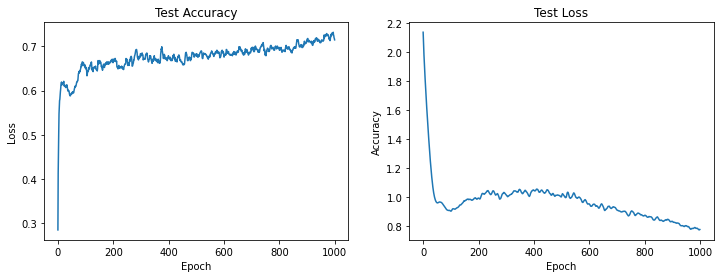

In [101]:
    # Plot the loss and accuracy graphs
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(test_accs)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Test Accuracy")
ax[1].plot(test_losses)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Test Loss")
plt.show()

Accuracy: 0.7145
Confusion Matrix:
[[103   0   0   0   1   0   0   0   0]
 [  0 146  31   0   0  19   0   0   0]
 [  0  32  47   0   0  29   1   1   0]
 [  0   0   0  39   0   0   3   0   0]
 [  1   4   0   0  26   1   2  15   0]
 [  0   1   1   1   1  23   0   0   0]
 [  0   0   1  15   1   0  30   0   5]
 [  0   0   0   0   8   1   0  23   0]
 [  0   0   0   2   0   0   2   4  21]]
Classification Report:
                                   precision    recall  f1-score   support

                         Islamist       0.99      0.99      0.99       104
       White Supremacist/Nativist       0.80      0.74      0.77       196
Anti-Government/Sovereign Citizen       0.59      0.43      0.49       110
      Environmental/Animal Rights       0.68      0.93      0.79        42
                            Other       0.70      0.53      0.60        49
                Conspiracy Theory       0.32      0.85      0.46        27
        Anarchist/Anti-Capitalist       0.79      0.58      0.67

C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


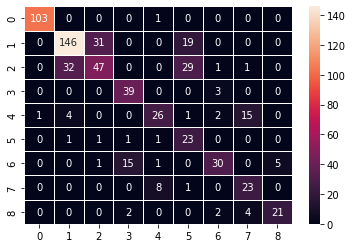

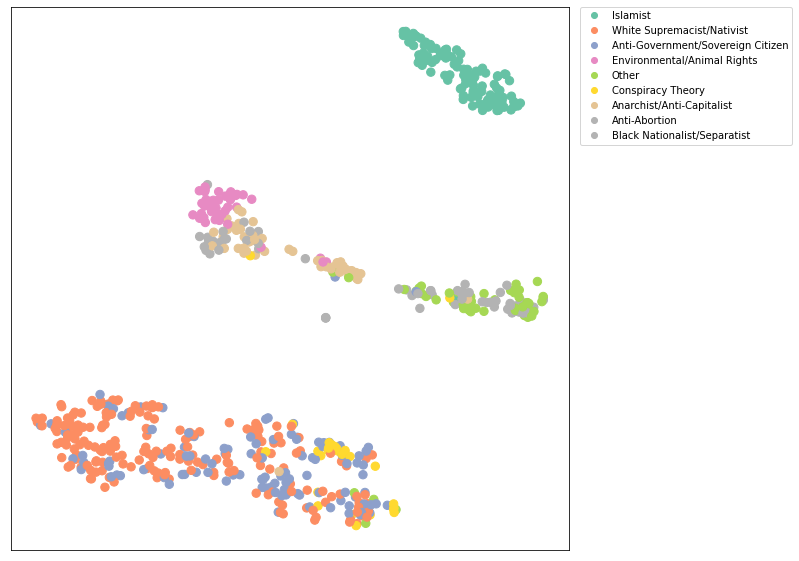

In [102]:
model.eval()
with torch.no_grad():
    output = model(x_test, edge_index_test)
    predictions = output.argmax(dim=1)
    accuracy = (predictions == y_test.long()).sum().item() / len(y_test)
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, predictions)
    print(cm)
    sns.heatmap(cm, linewidths=1, annot=True, fmt='g')
    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=my_list))
    visualize(output, y_test, my_list)

In [ ]:
from torch_geometric.nn import GCNConv

class G2R(torch.nn.Module):
    def __init__(self):
        super(G2R, self).__init__()

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x, edge_index):
       
        x = F.relu(self.conv1(x, edge_index))

        for conv in self.convs:       
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
model = GAT()
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
test_losses = []
test_accs = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    output = model(x_train, edge_index_train)  
    train_loss = criterion(output, y_train.long())
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

  
    model.eval()
    with torch.no_grad():
        output = model(x_test, edge_index_test)
        test_loss = criterion(output, y_test.long())
        test_losses.append(test_loss.item())
        predictions = output.argmax(dim=1)
        test_acc = (predictions == y_test.long()).sum().item() / len(y_test)
        test_accs.append(test_acc)


    # Print progress every 50 epochs
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_acc:.4f}")